In [1]:
#Import relevant modules
import numpy as np
import pandas as pd
import zipfile

In [2]:
city_name = 'Anaheim'
percentile_val = 98
main_zip = 'Alpha_Objective/' + city_name + '/' + city_name + '-'
main_zip_loc = 'Alpha_Objective/' + city_name + '/'
edges_file = 'Locations/' + city_name + '/edges.csv'
new_folder = 'Alpha_Objective'
specific_city = city_name + '.zip'
od_file = 'Locations/' + city_name + '/od.csv'
loc_ = 'constrained_approach/' + city_name + '/' + city_name +  '-constrained-'

# Implement 2005 Paper

In [3]:
alpha_values_2005 = ['1.00', '1.05', '1.10', '1.15', '1.20', '1.25', '1.30', '1.35', '1.40', '1.45', '1.50',
               '1.55', '1.60', '1.65', '1.70', '1.75', '1.80', '1.85', '1.90', '1.95', '2.00']

#Edges Data
edges = pd.read_csv(edges_file)
edges_arr = np.array(edges)
edges_arr = np.c_[edges_arr, np.array(range(len(edges)))]

OD_mat = pd.read_csv(od_file)
OD_arr__ = OD_mat['volume'].values

total_cost_2005 = []
final_beta_2005 = []
percentile_beta_2005 = []
for alpha_val in alpha_values_2005:
    print(alpha_val)
        
    df_flow = pd.read_csv(loc_+alpha_val+'/flow.csv', skiprows = 1)
    actual_cost = np.array(df_flow['actualCost'])
    flow = np.array(df_flow['flow'])
    total_cost_2005.append(sum([actual_cost[i]*flow[i] for i in range(len(actual_cost))]))
    

    flow_arr = np.array(df_flow)

    def find_edge2(tail_, head_):
        '''Finds edge index for given edge'''

        edges_filtered = edges_arr[edges_arr[:, 0] == tail_]
        edges_filtered = edges_filtered[edges_filtered[:, 1] == head_]

        return edges_filtered[0, -1]

    #Update Flow data
    edge_num_arr = []
    for j in df_flow.index:
        tail_value = int(flow_arr[j, 1])
        head_value = int(flow_arr[j, 2])
        edge_num_arr.append(find_edge2(tail_value, head_value))

    flow_arr = np.c_[flow_arr, edge_num_arr]
    flow_arr = flow_arr[flow_arr[:,-1].argsort()]
    
    cost_sol = flow_arr[:, 4]
    cost_sol = np.array([float(i) for i in cost_sol])
    
    paths_df = pd.read_csv(loc_+alpha_val+'/paths.csv', sep='delimiter', header=None)
    paths_df = paths_df.iloc[2:]
    paths_df = paths_df[0].str.split(',', 2, expand = True)
    paths_arr = np.array(paths_df)
    
    weights_df = pd.read_csv(loc_+alpha_val+'/weights.csv', skiprows = 1)
    weights_df_arr = np.array(weights_df)

    #Check if weight is at least 1/10th of the maximum weight
    small_arr = []
    for i in range(len(weights_df_arr)):
        if weights_df_arr[i, 1] > max(weights_df_arr[:, 1])/10:
            small_arr.append(i)

    paths_arr[:, 0] = [int(i) for i in paths_arr[:, 0]]
    #paths_arr_ue = np.append(paths_arr_ue, np.array(weig), axis=1)
    paths_arr = paths_arr[paths_arr[:, 0]>=min(small_arr)]
    paths_arr_new = paths_arr[:, 1:]
    paths_arr_new = np.vstack({tuple(row) for row in paths_arr_new})
    
    beta_val = []
    for OD_pair in range(int(paths_arr[-1, 1])):
        OD_arr = paths_arr_new[paths_arr_new[:, 0] == str(OD_pair)]
        all_paths_OD = []
        OD_tt_paths = []
        for path_idx, path_val in enumerate(OD_arr[:, 1]):
            all_edges = path_val.split(',')
            all_edges = [int(i) for i in all_edges]
            list_edges = []
            path_tt = 0
            for edge_values in all_edges:
                list_edges.append(edge_values)
                path_tt += cost_sol[edge_values]
            OD_tt_paths.append(path_tt)

        #Store max and min paths per OD pair
        path_OD_max = max(OD_tt_paths)
        path_OD_min = min(OD_tt_paths)
        
        #Find ratio of max and min
        if path_OD_max-path_OD_min>0.001:
            path_OD_beta = path_OD_max/path_OD_min
        else:
            path_OD_beta = 1
        
        beta_val.append(path_OD_beta)
        
    #Find percentile value of beta for this value of alpha
    beta_new_val = [item for item, count in zip(beta_val, OD_arr__) for i in range(count)]
    beta_dist = np.percentile(beta_new_val, percentile_val)

    #Find maximum value of beta for this value of alpha
    beta = max(beta_val) 
    final_beta_2005.append(beta)
    percentile_beta_2005.append(beta_dist)

1.00


/Users/devanshjalota/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/devanshjalota/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


1.05
1.10
1.15
1.20
1.25
1.30
1.35
1.40
1.45
1.50
1.55
1.60
1.65
1.70
1.75
1.80
1.85
1.90
1.95
2.00


# Convex Combination Objective

In [4]:
with zipfile.ZipFile(specific_city, 'r') as zip_ref:
    zip_ref.extractall(new_folder)

In [5]:
alpha_values = ['0', '.05', '.10', '.15', '.20', '.25', '.30', '.35', '.40', '.45', '.50',
               '.55', '.60', '.65', '.70', '.75', '.80', '.85', '.90', '.95', '1.00']

#Edges Data
edges = pd.read_csv(edges_file)
edges_arr = np.array(edges)
edges_arr = np.c_[edges_arr, np.array(range(len(edges)))]

OD_mat = pd.read_csv(od_file)
OD_arr__ = OD_mat['volume'].values

total_cost = []
final_beta = []
percentile_beta = []
for alpha_val in alpha_values:
    print(alpha_val)
    with zipfile.ZipFile(main_zip+alpha_val+'.zip', 'r') as zip_ref:
        zip_ref.extractall(main_zip_loc)
        
    df_flow = pd.read_csv(main_zip+alpha_val+'/flow.csv', skiprows = 1)
    actual_cost = np.array(df_flow['actualCost'])
    flow = np.array(df_flow['flow'])
    total_cost.append(sum([actual_cost[i]*flow[i] for i in range(len(actual_cost))]))
    

    flow_arr = np.array(df_flow)

    def find_edge2(tail_, head_):
        '''Finds edge index for given edge'''

        edges_filtered = edges_arr[edges_arr[:, 0] == tail_]
        edges_filtered = edges_filtered[edges_filtered[:, 1] == head_]

        return edges_filtered[0, -1]

    #Update Flow data
    edge_num_arr = []
    for j in df_flow.index:
        tail_value = int(flow_arr[j, 1])
        head_value = int(flow_arr[j, 2])
        edge_num_arr.append(find_edge2(tail_value, head_value))

    flow_arr = np.c_[flow_arr, edge_num_arr]
    flow_arr = flow_arr[flow_arr[:,-1].argsort()]
    
    cost_sol = flow_arr[:, 4]
    cost_sol = np.array([float(i) for i in cost_sol])
    
    paths_df = pd.read_csv(main_zip+alpha_val+'/paths.csv', sep='delimiter', header=None)
    paths_df = paths_df.iloc[2:]
    paths_df = paths_df[0].str.split(',', 2, expand = True)
    paths_arr = np.array(paths_df)
    
    weights_df = pd.read_csv(main_zip+alpha_val+'/weights.csv', skiprows = 1)
    weights_df_arr = np.array(weights_df)

    #Check if weight is at least 1/10th of the maximum weight
    small_arr = []
    for i in range(len(weights_df_arr)):
        if weights_df_arr[i, 1] > max(weights_df_arr[:, 1])/10:
            small_arr.append(i)

    paths_arr[:, 0] = [int(i) for i in paths_arr[:, 0]]
    #paths_arr_ue = np.append(paths_arr_ue, np.array(weig), axis=1)
    paths_arr = paths_arr[paths_arr[:, 0]>=min(small_arr)]
    paths_arr_new = paths_arr[:, 1:]
    paths_arr_new = np.vstack({tuple(row) for row in paths_arr_new})
    
    beta_val = []
    for OD_pair in range(int(paths_arr[-1, 1])):
        OD_arr = paths_arr_new[paths_arr_new[:, 0] == str(OD_pair)]
        all_paths_OD = []
        OD_tt_paths = []
        for path_idx, path_val in enumerate(OD_arr[:, 1]):
            all_edges = path_val.split(',')
            all_edges = [int(i) for i in all_edges]
            list_edges = []
            path_tt = 0
            for edge_values in all_edges:
                list_edges.append(edge_values)
                path_tt += cost_sol[edge_values]
            OD_tt_paths.append(path_tt)

        #Store max and min paths per OD pair
        path_OD_max = max(OD_tt_paths)
        path_OD_min = min(OD_tt_paths)
        
        #Find ratio of max and min
        if path_OD_max-path_OD_min>0.001:
            path_OD_beta = path_OD_max/path_OD_min
        else:
            path_OD_beta = 1
        
        beta_val.append(path_OD_beta)
        
    #Find percentile value of beta for this value of alpha
    beta_new_val = [item for item, count in zip(beta_val, OD_arr__) for i in range(count)]
    beta_dist = np.percentile(beta_new_val, percentile_val)

    #Find maximum value of beta for this value of alpha
    beta = max(beta_val) 
    final_beta.append(beta)
    percentile_beta.append(beta_dist)

0


/Users/devanshjalota/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/devanshjalota/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


.05
.10
.15
.20
.25
.30
.35
.40
.45
.50
.55
.60
.65
.70
.75
.80
.85
.90
.95
1.00


# Convex Combination Solution

In [6]:
edges = pd.read_csv(edges_file)
edges_arr = np.array(edges)
edges_arr = np.c_[edges_arr, np.array(range(len(edges)))]

flow_so = pd.read_csv(main_zip+'1.00/flow.csv', skiprows = 1)
flow_so_arr = np.array(flow_so)

flow_ue = pd.read_csv(main_zip+'0/flow.csv', skiprows = 1)
flow_ue_arr = np.array(flow_ue)

def find_edge2(tail_, head_):
    '''Finds edge index for given edge'''
    
    edges_filtered = edges_arr[edges_arr[:, 0] == tail_]
    edges_filtered = edges_filtered[edges_filtered[:, 1] == head_]
    
    return edges_filtered[0, -1]

#Update Flow UE data
edge_num_ue_arr = []
for j in flow_ue.index:
    tail_value = int(flow_ue_arr[j, 1])
    head_value = int(flow_ue_arr[j, 2])
    edge_num_ue_arr.append(find_edge2(tail_value, head_value))

flow_ue_arr = np.c_[flow_ue_arr, edge_num_ue_arr]

#Update Flow SO data
edge_num_so_arr = []
for j in flow_so.index:
    tail_value = int(flow_so_arr[j, 1])
    head_value = int(flow_so_arr[j, 2])
    edge_num_so_arr.append(find_edge2(tail_value, head_value))

flow_so_arr = np.c_[flow_so_arr, edge_num_so_arr]

#Sort flows based on edge indices
flow_ue_arr = flow_ue_arr[flow_ue_arr[:,-1].argsort()]
flow_so_arr = flow_so_arr[flow_so_arr[:,-1].argsort()]

#Store the UE and SO solutions
x_UE_sol = flow_ue_arr[:, 6]
y_SO_sol = flow_so_arr[:, 6]

x_UE_sol = np.array([float(i) for i in x_UE_sol])
y_SO_sol = np.array([float(i) for i in y_SO_sol])

#Define the link latency functions
def link_latency(a_val, power_val, link_ff_cost, link_capacity, link_flow):
    '''Calculates latency of link'''
    return link_ff_cost*(1+a_val*(link_flow/link_capacity)**power_val)

def get_travel_time(sol_implement):
    '''Find the total travel time in a given network'''
    
    return sum([sol_implement[j_val]*link_latency(0.15, 4, int(flow_so_arr[j_val, 3]),  edges_arr[j_val, 3], sol_implement[j_val]) for j_val in range(len(sol_implement))])


paths_so = pd.read_csv(main_zip+'1.00/paths.csv', sep='delimiter', header=None)
paths_ue = pd.read_csv(main_zip+'0/paths.csv', sep='delimiter', header=None)

paths_so = paths_so.iloc[2:]
paths_so = paths_so[0].str.split(',', 2, expand = True)
paths_arr_so = np.array(paths_so)

paths_ue = paths_ue.iloc[2:]
paths_ue = paths_ue[0].str.split(',', 2, expand = True)
paths_arr_ue = np.array(paths_ue)

weights_ue = pd.read_csv(main_zip+'0/weights.csv', skiprows = 1)
weights_ue_arr = np.array(weights_ue)

#Check if weight is at least 1/10th of the maximum weight
small_arr = []
for i in range(len(weights_ue_arr)):
    if weights_ue_arr[i, 1] > max(weights_ue_arr[:, 1])/2:
        small_arr.append(i)
        
#Find unique paths
paths_arr_ue[:, 0] = [int(i) for i in paths_arr_ue[:, 0]]
paths_arr_ue = paths_arr_ue[paths_arr_ue[:, 0]>=min(small_arr)]
paths_arr_ue_new = paths_arr_ue[:, 1:]
paths_arr_ue_new = np.vstack({tuple(row) for row in paths_arr_ue_new})

weights_so = pd.read_csv(main_zip+'1.00/weights.csv', skiprows = 1)
weights_so_arr = np.array(weights_so)

#Check if weight is at least 1/10th of the maximum weight
small_arr = []
for i in range(len(weights_so_arr)):
    if weights_so_arr[i, 1] > max(weights_so_arr[:, 1])/10:
        small_arr.append(i)

#Find unique paths
paths_arr_so[:, 0] = [int(i) for i in paths_arr_so[:, 0]]
paths_arr_so = paths_arr_so[paths_arr_so[:, 0]>=min(small_arr)]
paths_arr_so_new = paths_arr_so[:, 1:]
paths_arr_so_new = np.vstack({tuple(row) for row in paths_arr_so_new})

OD_dict_UE = {}
OD_path_lengths_UE = {}
for OD_pair in range(int(paths_arr_ue[-1, 1])):
    OD_arr = paths_arr_ue_new[paths_arr_ue_new[:, 0] == str(OD_pair)]
    all_paths_OD = []
    OD_tt_paths = []
    for path_idx, path_val in enumerate(OD_arr[:, 1]):
        all_edges = path_val.split(',')
        all_edges = [int(i) for i in all_edges]
        list_edges = []
        path_tt = 0
        
        for edge_values in all_edges:
            list_edges.append(edge_values)
            #path_tt += cost_sol[edge_values]
            path_tt += link_latency(0.15, 4, int(flow_ue_arr[edge_values, 3]),  edges_arr[edge_values, 3], x_UE_sol[edge_values])

        OD_tt_paths.append(path_tt)

        #if list_edges not in all_paths_OD:
        all_paths_OD.append(list_edges)
    if OD_pair%100 == 0:
        print(OD_pair)
    OD_dict_UE[OD_pair] = all_paths_OD
    OD_path_lengths_UE[OD_pair] = OD_tt_paths
    
OD_dict_SO = {}
OD_path_lengths_SO = {}
for OD_pair in range(int(paths_arr_so[-1, 1])):
    OD_arr = paths_arr_so_new[paths_arr_so_new[:, 0] == str(OD_pair)]
    all_paths_OD = []
    OD_tt_paths = []
    for path_val in OD_arr[:, 1]:
        all_edges = path_val.split(',')
        all_edges = [int(i) for i in all_edges]
        list_edges = []
        path_tt = 0

        for edge_values in all_edges:
            list_edges.append(edge_values)
            path_tt += link_latency(0.15, 4, int(flow_so_arr[edge_values, 3]),  edges_arr[edge_values, 3], y_SO_sol[edge_values])

        OD_tt_paths.append(path_tt)

        #if list_edges not in all_paths_OD:
        all_paths_OD.append(list_edges)
    if OD_pair%100 == 0:
        print(OD_pair)
    OD_dict_SO[OD_pair] = all_paths_OD
    OD_path_lengths_SO[OD_pair] = OD_tt_paths
    
def dict_union(dict_UE, dict_SO):
    '''Find the union of two dictionaries'''
    dict_total = {}
    for OD_pair in dict_SO:
        a = []#dict_total[OD_pair]
        for j in dict_SO[OD_pair]:
            #if j not in dict_UE[OD_pair]:
            a.append(j)
        for j in dict_UE[OD_pair]:
            if j not in dict_SO[OD_pair]:
                a.append(j)
                
        dict_total[OD_pair] = a
        
    return dict_total

#Take the union of the two dictionaries to find total set of OD pairs
OD_dict = dict_union(OD_dict_UE, OD_dict_SO)

OD_mat = pd.read_csv(od_file)
OD_arr = OD_mat['volume'].values

def beta_calc(OD_dict, convex_comb):
    '''Calculate beta for a given alpha value'''
    
    beta_val = []
    for OD_pair in OD_dict:
        path_OD = []
        for path in OD_dict[OD_pair]:
            path_tt = 0
            for edge in path:
                path_tt += link_latency(0.15, 4, int(flow_so_arr[edge, 3]),  edges_arr[edge, 3], convex_comb[edge])

            path_OD.append(path_tt)

        #Store max and min paths per OD pair
        path_OD_max = max(path_OD)
        path_OD_min = min(path_OD)
        
        if path_OD_max-path_OD_min>0.001:
            path_OD_beta = path_OD_max/path_OD_min
        else:
            path_OD_beta = 1

        #Find ratio of max and min
        beta_val.append(path_OD_beta)

    #Find maximum value of beta for this value of alpha
    beta = max(beta_val)
    
    return beta

def beta_calc_dist(OD_dict, convex_comb, percentile_val):
    '''Calculate beta for a given alpha value'''
    
    beta_val = []
    for OD_pair in OD_dict:
        path_OD = []
        for path_idx, path in enumerate(OD_dict[OD_pair]):
            path_tt = 0
            for edge in path:
                path_tt += link_latency(0.15, 4, int(flow_so_arr[edge, 3]),  edges_arr[edge, 3], convex_comb[edge])

            path_OD.append(path_tt)

        
        
        #Store max and min paths per OD pair
        path_OD_max = max(path_OD)
        path_OD_min = min(path_OD)
        
        if path_OD_max-path_OD_min>0.001:
            path_OD_beta = path_OD_max/path_OD_min
        else:
            path_OD_beta = 1

        #Find ratio of max and min
        beta_val.append(path_OD_beta)

    #Find percentile value of beta for this value of alpha
    beta_new_val = [item for item, count in zip(beta_val, OD_arr) for i in range(count)]
    beta_dist = np.percentile(beta_new_val, percentile_val)
    
    return beta_dist, beta_new_val

#Calculate for each value of alpha the corresponding travel time
total_tt_solution = []
beta_alpha_solution = []
beta_alpha_dist_solution = []
alpha_vals_solution = np.linspace(0, 1, 101)
global_beta = {}
for i in alpha_vals_solution:
    convex_comb = i*x_UE_sol + (1-i)*y_SO_sol
    total_tt_alpha = get_travel_time(convex_comb)
    total_tt_solution.append(total_tt_alpha)
    print(i)
    #If at extremes then calculate beta according to UE and SO solutions respectively
    if i == 0:
        beta = beta_calc(OD_dict_SO, convex_comb)
        beta2, beta_array = beta_calc_dist(OD_dict_SO, convex_comb, 98)
        global_beta[i] = beta_array
    elif i == 1:
        beta2, beta_array = beta_calc_dist(OD_dict_UE, convex_comb, 98)
        global_beta[i] = beta_array
        beta = beta_calc(OD_dict_UE, convex_comb)
    else:
        beta2, beta_array = beta_calc_dist(OD_dict, convex_comb, 98)
        global_beta[i] = beta_array
        beta = beta_calc(OD_dict, convex_comb)
    print(i)
    beta_alpha_dist_solution.append(beta2)
    beta_alpha_solution.append(beta)

/Users/devanshjalota/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/devanshjalota/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/devanshjalota/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/devanshjalota/anaconda3/lib/python3.7/site-pac

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
0.0
0.0
0.01
0.01
0.02
0.02
0.03
0.03
0.04
0.04
0.05
0.05
0.06
0.06
0.07
0.07
0.08
0.08
0.09
0.09
0.1
0.1
0.11
0.11
0.12
0.12
0.13
0.13
0.14
0.14
0.15
0.15
0.16
0.16
0.17
0.17
0.18
0.18
0.19
0.19
0.2
0.2
0.21
0.21
0.22
0.22
0.23
0.23
0.24
0.24
0.25
0.25
0.26
0.26
0.27
0.27
0.28
0.28
0.29
0.29
0.3
0.3
0.31
0.31
0.32
0.32
0.33
0.33
0.34
0.34
0.35000000000000003
0.35000000000000003
0.36
0.36
0.37
0.37
0.38
0.38
0.39
0.39
0.4
0.4
0.41000000000000003
0.41000000000000003
0.42
0.42
0.43
0.43
0.44
0.44
0.45
0.45
0.46
0.46
0.47000000000000003
0.47000000000000003
0.48
0.48
0.49
0.49
0.5
0.5
0.51
0.51
0.52
0.52
0.53
0.53
0.54
0.54
0.55
0.55
0.56
0.56
0.5700000000000001
0.5700000000000001
0.58
0.58
0.59
0.59
0.6
0.6
0.61
0.61
0.62
0.62
0.63
0.63
0.64
0.64
0.65
0.65
0.66
0.66
0.67
0.67
0.68
0.68
0.6900000000000001
0.6900000000000001
0.7000000000000001
0.7000000000000001
0.71

# Pareto Frontier

In [7]:
import matplotlib.pyplot as plt

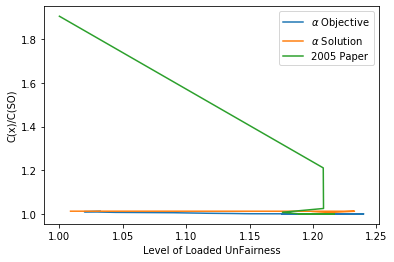

In [8]:
plt.plot(final_beta, total_cost/total_cost[-1])
plt.plot(beta_alpha_solution, total_tt_solution/total_tt_solution[0])
plt.plot(final_beta_2005, total_cost_2005/total_cost_2005[-1])
plt.xlabel('Level of Loaded UnFairness')
plt.ylabel('C(x)/C(SO)')
plt.legend([r'$\alpha$ Objective', r'$\alpha$ Solution', '2005 Paper'])

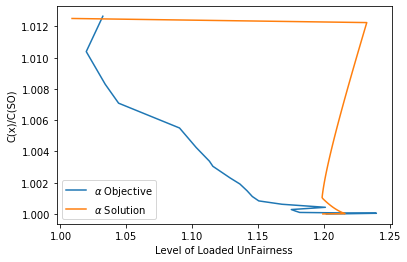

In [9]:
plt.plot(final_beta, total_cost/total_cost[-1])
plt.plot(beta_alpha_solution, total_tt_solution/total_tt_solution[0])
plt.xlabel('Level of Loaded UnFairness')
plt.ylabel('C(x)/C(SO)')
plt.legend([r'$\alpha$ Objective', r'$\alpha$ Solution'])

# Pareto Frontier for Percentiles

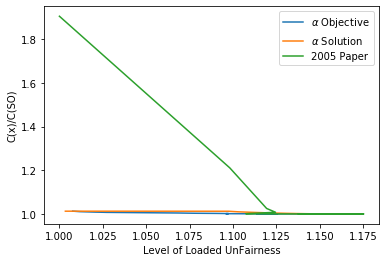

In [10]:
plt.plot(percentile_beta, total_cost/total_cost[-1])
plt.plot(beta_alpha_dist_solution, total_tt_solution/total_tt_solution[0])
plt.plot(percentile_beta_2005, total_cost_2005/total_cost_2005[-1])
plt.xlabel('Level of Loaded UnFairness')
plt.ylabel('C(x)/C(SO)')
plt.legend([r'$\alpha$ Objective', r'$\alpha$ Solution', '2005 Paper'])

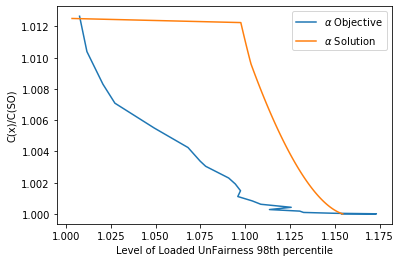

In [11]:
plt.plot(percentile_beta, total_cost/total_cost[-1])
plt.plot(beta_alpha_dist_solution, total_tt_solution/total_tt_solution[0])
plt.xlabel('Level of Loaded UnFairness {}th percentile'.format(98))
plt.ylabel('C(x)/C(SO)')
plt.legend([r'$\alpha$ Objective', r'$\alpha$ Solution'])